In [1]:
import cv2
import json
import math
import os
import os.path
import re
import tempfile
import airsim
import numpy as np
from PIL import Image
from matplotlib import pyplot
import quickstart as util
import utils_KITTI as utilkitti

Using TensorFlow backend.
/home/islab/.local/share/virtualenvs/depth_prediction-uX_uZt9E/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/islab/.local/share/virtualenvs/depth_prediction-uX_uZt9E/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/islab/.local/share/virtualenvs/depth_prediction-uX_uZt9E/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) /

In [2]:
# 資料路徑
DATA_PATH = '/home/islab/Documents/drone/depth_prediction/data/random/data/2020-03-30-01-35/depth_planner/2020-03-30-02-59-25'
GREY_PIC_PATH = '/home/islab/Documents/drone/depth_prediction/result/vis_depth/2020-03-30-02-59-25/visualized_depth'
RESULT_PATH = '/home/islab/Documents/drone/depth_prediction/depth_differ/result/2020-03-30-02-59-25'

# Model Input 解析度設定
INPUT_HEIGHT = 320
INPUT_WIDTH = 384

#
ARROW_SIZE = 50

/home/islab/Documents/drone/depth_prediction/depth_differ/result/2020-03-30-02-59-25/3D_analysis/001.png
[ 9173.26757812 13815.52929688 16791.50244141 10375.56555176
 21223.47869873 25447.88885498  8593.06707764  6142.33209229]
[0.99984373 0.99977608 0.99954734 0.99899699 0.99503656 0.99393424
 0.99846052 0.99983659]
/home/islab/Documents/drone/depth_prediction/depth_differ/result/2020-03-30-02-59-25/3D_analysis/002.png
[6.38357129e+03 1.43488069e+04 9.84884326e+03 3.67809846e+04
 1.08746017e+05 9.26305909e+04 1.88863740e+04 1.04422852e+02]
[0.99992046 0.99962033 0.99941025 0.98523814 0.96718741 0.98033566
 0.99550655 0.99995581]
/home/islab/Documents/drone/depth_prediction/depth_differ/result/2020-03-30-02-59-25/3D_analysis/003.png
[18741.4140625  24533.65039062  5792.23632812 26529.71600342
 59713.34503174 42241.17633057 10490.54559326  1432.99829102]
[0.99979805 0.99952319 0.99964247 0.97315722 0.98101418 0.9914078
 0.99864908 0.99989975]
/home/islab/Documents/drone/depth_prediction

/home/islab/Documents/drone/depth_prediction/depth_differ/result/2020-03-30-02-59-25/3D_analysis/041.png
[197693.76885986 119419.40130615  50057.94726562  31672.01989746
  30575.35638428 122719.36523438 209553.16223145 214069.44830322]
[0.14496124 0.87882263 0.96063767 0.97724208 0.98618262 0.96332891
 0.89969811 0.61369863]
/home/islab/Documents/drone/depth_prediction/depth_differ/result/2020-03-30-02-59-25/3D_analysis/042.png
[178411.64892578 105899.73504639  19983.6315918    6352.46453857
  11528.29058838  89981.92486572 142985.89996338 150675.34661865]
[0.2846952  0.92511129 0.9904058  0.99605497 0.99585282 0.97046875
 0.92274311 0.71857411]
/home/islab/Documents/drone/depth_prediction/depth_differ/result/2020-03-30-02-59-25/3D_analysis/043.png
[1.40203110e+05 9.53429821e+04 1.09685089e+04 1.14222656e+02
 5.41905042e+03 1.78152129e+04 2.06184906e+04 6.39367426e+04]
[0.54305978 0.94328445 0.99692337 0.99995813 0.99818387 0.9946453
 0.99022975 0.909     ]
/home/islab/Documents/drone/

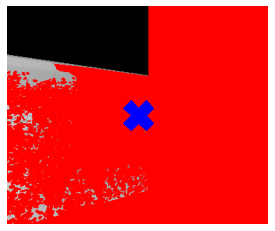

In [3]:
result_image_folder_path = os.path.join(RESULT_PATH, '3D_analysis')
if not os.path.exists(result_image_folder_path):
    os.makedirs(result_image_folder_path)
for i in range(50):
    # 讀取影像
    n = "%03d" % (i+1)
    depth, scale = utilkitti.read_pfm(os.path.join(DATA_PATH, str(n)+'.pfm'))
    X = np.zeros((INPUT_HEIGHT, INPUT_WIDTH))
    Y = np.zeros((INPUT_HEIGHT, INPUT_WIDTH))
    im = Image.open(os.path.join(GREY_PIC_PATH, str(n)+'.png'))
    im_rgb = im.convert("RGB")
    danger = False
    for j in range(INPUT_HEIGHT):
        for k in range(INPUT_WIDTH):
            Y[j, k] = depth[j, k] * (j - 160) / 192
            X[j, k] = depth[j, k] * (k - 192) / 192
            if abs(X[j, k]) <= 0.5 and abs(Y[j, k]) <= 0.25:
                if depth[j, k] < 15:
                    danger = True
                  
    #
    #WN N EN E ES S WS W
    safe_count = np.array([0, 0, 0, 0, 0, 0, 0, 0])
    safe_weight_count = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    danger_count = np.array([0, 0, 0, 0, 0, 0, 0, 0])
    danger_prop = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    safe_dir = 0
    max_safe_weight = 0.0
    danger_area_count = 0
    
    if danger:
        for j in range(INPUT_HEIGHT):
            for k in range(INPUT_WIDTH):
                if abs(X[j, k]) <= 2.5 and abs(Y[j, k]) <= 2.5:
                    ind_1 = 0
                    ind_2 = 0
                    temp_y = Y[j, k]
                    if Y[j, k] == 0.0:
                        temp_y = 1.0
                        
                    if X[j, k] <= 0.0 and Y[j, k] <= 0.0:
                        ind_1 = 0
                        if abs(X[j, k]/temp_y) > 1:
                            ind_2 = 7
                        else:
                            ind_2 = 1
                    if X[j, k] >= 0.0 and Y[j, k] <= 0.0:
                        ind_1 = 2
                        if abs(X[j, k]/temp_y) > 1:
                            ind_2 = 3
                        else:
                            ind_2 = 1
                    if X[j, k] >= 0.0 and Y[j, k] >= 0.0:
                        ind_1 = 4
                        if abs(X[j, k]/temp_y) > 1:
                            ind_2 = 3
                        else:
                            ind_2 = 5
                    if X[j, k] <= 0.0 and Y[j, k] >= 0.0:
                        ind_1 = 6
                        if abs(X[j, k]/temp_y) > 1:
                            ind_2 = 7
                        else:
                            ind_2 = 5
                        
                    if depth[j, k] > 10:
                        im_rgb.putpixel((k, j), (0, 256, 0))
                        safe_weight_count[ind_1] += (depth[j, k] * depth[j, k])
                        safe_count[ind_1] += 1
                        safe_weight_count[ind_2] += (depth[j, k] * depth[j, k])
                        safe_count[ind_2] += 1
                    else:
                        im_rgb.putpixel((k, j), (256, 0, 0))
                        danger_count[ind_1] += 1
                        danger_count[ind_2] += 1
        for j in range(8):
            danger_prop[j] = danger_count[j] / (danger_count[j] + safe_count[j])
            if danger_prop[j] < 0.3 and safe_weight_count[j] > max_safe_weight:
                max_safe_weight = safe_weight_count[j]
                safe_dir = j
            else:
                danger_area_count += 1  
    
    pyplot.clf()
    pyplot.axis('off')
    pyplot.imshow(im_rgb)
    if danger:
        #max_area = np.argmax(counter)
        if danger_area_count == 8:
            pyplot.plot(INPUT_WIDTH/2, INPUT_HEIGHT/2, color = 'b', marker = 'X', markersize = 30)
        elif safe_dir == 0:
            pyplot.arrow(INPUT_WIDTH/2, INPUT_HEIGHT/2, -ARROW_SIZE, -ARROW_SIZE, color='b', head_width=10)
        elif safe_dir == 1:
            pyplot.arrow(INPUT_WIDTH/2, INPUT_HEIGHT/2, 0, -ARROW_SIZE, color='b', head_width=10)
        elif safe_dir == 2:
            pyplot.arrow(INPUT_WIDTH/2, INPUT_HEIGHT/2, ARROW_SIZE, -ARROW_SIZE, color='b', head_width=10)
        elif safe_dir == 7:
            pyplot.arrow(INPUT_WIDTH/2, INPUT_HEIGHT/2, -ARROW_SIZE, 0, color='b', head_width=10)
        elif safe_dir == 3:
            pyplot.arrow(INPUT_WIDTH/2, INPUT_HEIGHT/2, ARROW_SIZE, 0, color='b', head_width=10)
        elif safe_dir == 6:
            pyplot.arrow(INPUT_WIDTH/2, INPUT_HEIGHT/2, -ARROW_SIZE, ARROW_SIZE, color='b', head_width=10)
        elif safe_dir == 5:
            pyplot.arrow(INPUT_WIDTH/2, INPUT_HEIGHT/2, 0, ARROW_SIZE, color='b', head_width=10)
        elif safe_dir == 4:
            pyplot.arrow(INPUT_WIDTH/2, INPUT_HEIGHT/2, ARROW_SIZE, ARROW_SIZE, color='b', head_width=10)
    # 儲存結果
    pyplot.savefig(os.path.join(result_image_folder_path, str(n)+'.png'))
    print(os.path.join(result_image_folder_path, str(n)+'.png'))
    print(safe_weight_count)
    print(danger_prop)